In [6]:
# viz
%pylab inline
# util
import os
import importlib
import util
importlib.reload(util)
util.figsize()
# num
import pandas as pd
from scipy import stats
# ml
from sklearn import *

Populating the interactive namespace from numpy and matplotlib


In [7]:
# (sub)plot ref
splot = subplot

## Feature learning

Because we are mortal and our engineering effort is finite.

In [8]:
# load numeric data from a file
# it is assumed that 
def load_numpy_dataset(filepath):
    dat = np.load(filepath)
    return preprocessing.StandardScaler().fit_transform(dat[:,:-1]), dat[:,-1]

In [18]:
# get the engineered features from the previous section
gabor_features, disease = load_numpy_dataset('data/feats1D.npy')
gabor_res0 = util.l1o_model_validation(gabor_features, disease)
bovw_features, pet = load_numpy_dataset('data/feats2D.npy')
bovw_res0 = util.l1o_model_validation(bovw_features, pet,
                                      classifier=linear_model.LogisticRegression())
print('gabor0: {:.2f}\nbovw0: {:.2f}'.format(gabor_res0, bovw_res0))

gabor0: 0.97
bovw0: 0.62


### Principal Component Analysis and Linear Discriminant Analysis

With PCA we can obtain an unsupervised dimensionality reduction, while LDA is a supervised technique.

<img src=images/lda_1.png>

In [19]:
def plot_progressive_pca_validation(features, labels, ds_name,
                                    classifier=neighbors.KNeighborsClassifier(1)):
    ncs = np.arange(features.shape[1])+1
    pca_res = []
    for nc in ncs:
        pca = decomposition.PCA(n_components=nc)
        pca_res.append(util.l1o_model_validation(features,
                                                 labels,
                                                 normalizer=pca,
                                                 classifier=classifier))
    plot(ncs, pca_res);
    xticks(ncs[::2])
    util.xlabel('#features'); util.ylabel('accuracy')
    util.title('Feature selection based on PCA ({})'.format(ds_name))

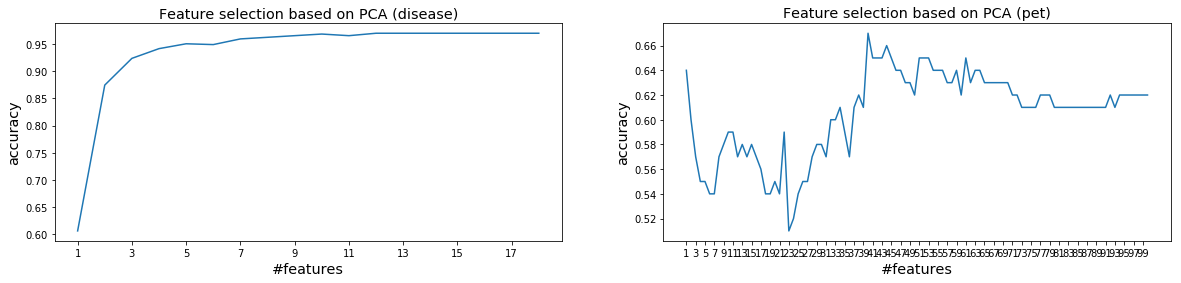

In [20]:
util.figsize(20, 4)
splot(121); plot_progressive_pca_validation(gabor_features, disease, 'disease')
splot(122); plot_progressive_pca_validation(bovw_features, pet, 'pet',
                                            classifier=linear_model.LogisticRegression())
util.figsize()

Results of progressively adding principal components to the disease- and pet- datasets. In case of many features, using PCA may greatly reduce model size.

#### Linear Discriminant Analysis

In [21]:
# use PCA for selecting 2 features
pca_feats = decomposition.PCA(n_components=2) \
                .fit_transform(gabor_features)
# use LDA for selecting 2 features
lda_feats = discriminant_analysis.LinearDiscriminantAnalysis() \
                .fit_transform(gabor_features, disease)

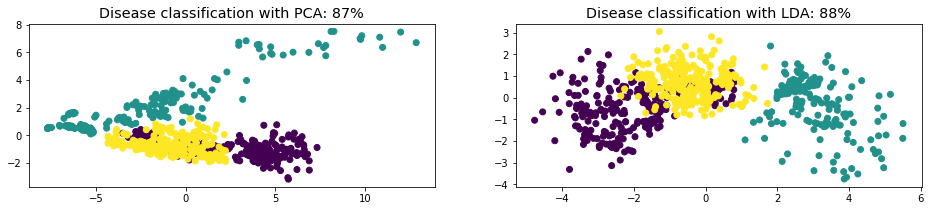

In [22]:
splot(121); scatter(pca_feats[:,0], pca_feats[:,1], c=disease);
util.title('Disease classification with PCA: {:.0f}%'
           .format(100*util.l1o_model_validation(pca_feats, disease)))
splot(122); scatter(lda_feats[:,0], lda_feats[:,1], c=disease);
util.title('Disease classification with LDA: {:.0f}%'
           .format(100*util.l1o_model_validation(lda_feats, disease)))

> Making the features better linearly seperable does not help when using a nearest neighbor classifier!

In [23]:
# use a linear SVM to boost performance on LDA features
print('PCA+SVM: {:.0f}%\nLDA+SVM: {:.0f}%'.format(
    100*util.l1o_model_validation(pca_feats, disease, svm.SVC(kernel='linear')),
    100*util.l1o_model_validation(lda_feats, disease, svm.SVC(kernel='linear'))))

PCA+SVM: 84%
LDA+SVM: 89%
